In [1]:
import pickle
import json
import numpy as np
import os

import tensorflow_core as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import pandas as pd
import seaborn as sb
import scipy as sp
import sklearn.preprocessing as skp
import skimage
import skimage.io
import skimage.transform
import numpy as np

# test local only
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
MODEL_ID = 3
DATA_DIR = "data/cifa10"

# Load data

In [3]:
import model_cifa10.file_utils as file_utils

names, data, labels = file_utils.read_data(\
    DATA_DIR, is_train=True)

# data = data[5000:5000+t_train_size]
# labels = labels[5000:5000+t_train_size]

t_names, t_data, t_labels = file_utils.read_data(\
    DATA_DIR, is_train=False)

# t_data = t_data[1000:1000+t_test_size]
# t_labels = t_labels[1000:1000+t_test_size]

evaluation_size = 1000
evaluation_pos = 2000
t_data_eva = t_data[evaluation_pos:evaluation_pos+evaluation_size]
t_labels_eva = t_labels[evaluation_pos:evaluation_pos+evaluation_size]

In [4]:
import model_cifa10.file_utils as file_utils

def plot_images(images, label_ids, label_names):
    fig, axes = plt.subplots(6, 6, figsize=(8,8))
    fig.tight_layout()

    # fig.subplots_adjust(hspace=0.5)

    for i, ax in enumerate(axes.flat): # from 0 -> 8

        ax.imshow(file_utils.scale_img(images[i]), \
                  interpolation="spline16")
            
        _class_ = label_names[label_ids[i]]
        
        xlabel = "{0}".format(_class_)

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

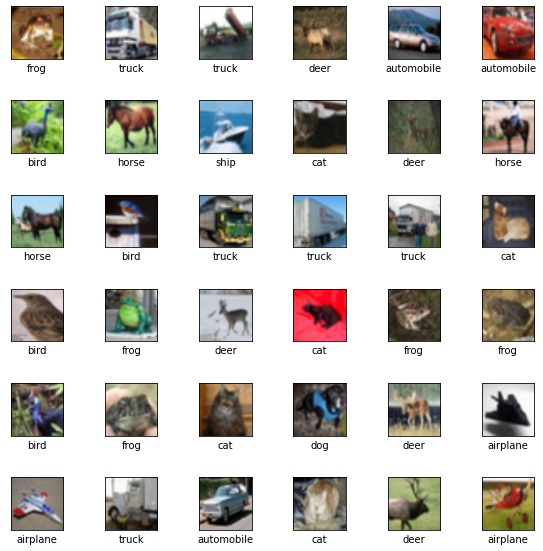

In [5]:
plot_images(data[0:36], labels[0:36], names)

# Convert to one hot

In [6]:
def convert_to_one_hot(y_dataset, num_labels):
    y_one_hot = np.array([-99.] * num_labels)
    for val in y_dataset:
        one_hot = np.array(\
            [0.] * int(val) + [1.] + [0.] * int(num_labels - val - 1))
        
        y_one_hot = np.vstack((y_one_hot, one_hot))
    
    return y_one_hot[1:] # remove first dummy

y_train_one_hot = convert_to_one_hot(labels, len(names))
y_test_one_hot = convert_to_one_hot(t_labels, len(t_names))
y_test_one_hot_eva = convert_to_one_hot(t_labels_eva, len(t_names))

# Plot augments

In [7]:
def plot_augments(images):
        
    # 3x3 grid
    fig, axes = plt.subplots(3, 4, figsize=(8, 8))
    fig.tight_layout(h_pad=1.5, w_pad=0.05)

    for i, ax in enumerate(axes.flat): # from 0 -> 8
        ax.imshow(images[i], \
            interpolation="spline16")
        
        xlabel = "{0}".format(f"CIFAR10-{i}")

        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [8]:
offset = 50
batch_1 = data[offset:offset+4]

sess = tf.Session()

2022-01-31 10:44:46.837614: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-31 10:44:46.843747: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-31 10:44:46.843812: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: inspiron15-7000
2022-01-31 10:44:46.843821: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: inspiron15-7000
2022-01-31 10:44:46.844010: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.63.1
2022-01-31 10:44:46.844045: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.63.1
2022-01-31 10:44:46.844053: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.63.1
2022-01-31 10:44:46.844866: I tensorflow/core/platfo

(12, 224, 224, 1)


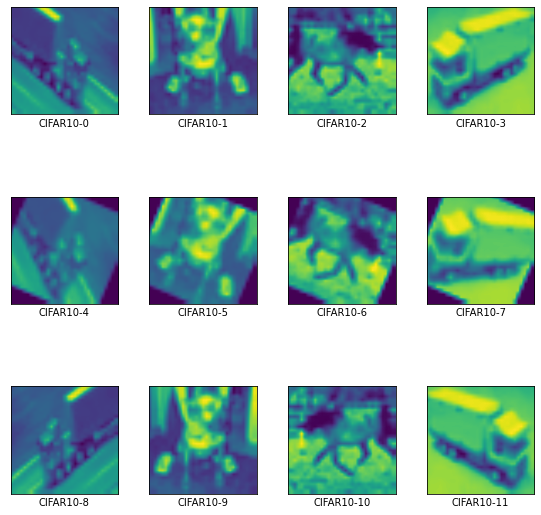

In [10]:
import model_cifa10.tf_preprocess_img as tf_preproc

imgs = sess.run(tf_preproc.tf_augment_images(tf_preproc.tf_preprocess_images(batch_1, is_train=True)))
print(imgs.shape)

plot_augments(np.reshape(imgs, (-1, 224, 224)))

# Train model

In [10]:
sess.close()

In [11]:
from model_cifa10.model import Model

ml_model = Model(MODEL_ID, "meta")
ml_model.init_session()
ml_model.restore_session(f"meta/model{MODEL_ID}/obj-detect-{MODEL_ID}")

try:
    ml_model.training_loop(data, labels, y_train_one_hot, t_data_eva, t_labels_eva, y_test_one_hot_eva)

# GOOGLE COLAB support throw KeyboardInterrupt error when interupt kernel
except KeyboardInterrupt:
    ml_model.save_model()
    ml_model.save_metrics()
    
    print("===== SAVE MODEL SUCCESSFULLY =====")
    exit(1)
else:
    print("UNKNOWN ERROR!!!")

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

INFO:tensorflow:Restoring parameters from meta